In [1]:
! pip install xgboost

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
# load data
df = pd.read_excel('Data/data_all.xlsx')

df.head()

,time,DA_price,grid load [MWh],Residual load [MWh],Total [MWh],Photovoltaics and wind [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh]
0,2019-01-01 00:00:00,28.32,43213.25,19264.50,51011.0,23948.75,5069.00,18879.75,0.0
1,2019-01-01 01:00:00,10.07,41275.75,15607.00,51017.0,25668.75,5042.25,20626.50,0.0
2,2019-01-01 02:00:00,-4.08,40187.50,12803.50,51438.0,27384.00,5028.50,22355.50,0.0
3,2019-01-01 03:00:00,-9.91,39909.00,10898.75,52608.0,29010.25,4977.75,24032.50,0.0
4,2019-01-01 04:00:00,-7.41,40258.00,9898.75,53566.0,30359.25,4907.25,25452.00,0.0


In [4]:
# Set time column as Index column
df.set_index('time', inplace=True)

In [5]:
# Create lag features
df['lag_1'] = df['DA_price'].shift(1)
df['lag_24'] = df['DA_price'].shift(24)

# Time features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

# Exogenous features
exog_features = ['Residual load [MWh]', 'Photovoltaics and wind [MWh]']

# Final feature set
features = ['lag_1', 'lag_24', 'hour', 'dayofweek'] + exog_features
df = df.dropna()  # Drop rows with NaN from lagging

In [6]:
train = df[:"2024-11-30"]
test = df["2024-12-01":]

X_train = train[features]
y_train = train['DA_price']

X_test = test[features]
y_test = test['DA_price']

In [7]:
# Clean feature column names
X_train.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_train.columns]
X_test.columns = X_train.columns  # Ensure test columns match

 ValueError: feature_names must be string, and may not contain [, ] or <
means that some of your column names (feature names) in X_train contain invalid characters — such as [ or ].




In [8]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [11]:
# Make predictions and evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mpe = np.max(np.abs(y_test - y_pred))


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MPE: {mpe:.2f} €/MWh")


MAE: 10.98
RMSE: 24.72
MPE: 358.02 €/MWh


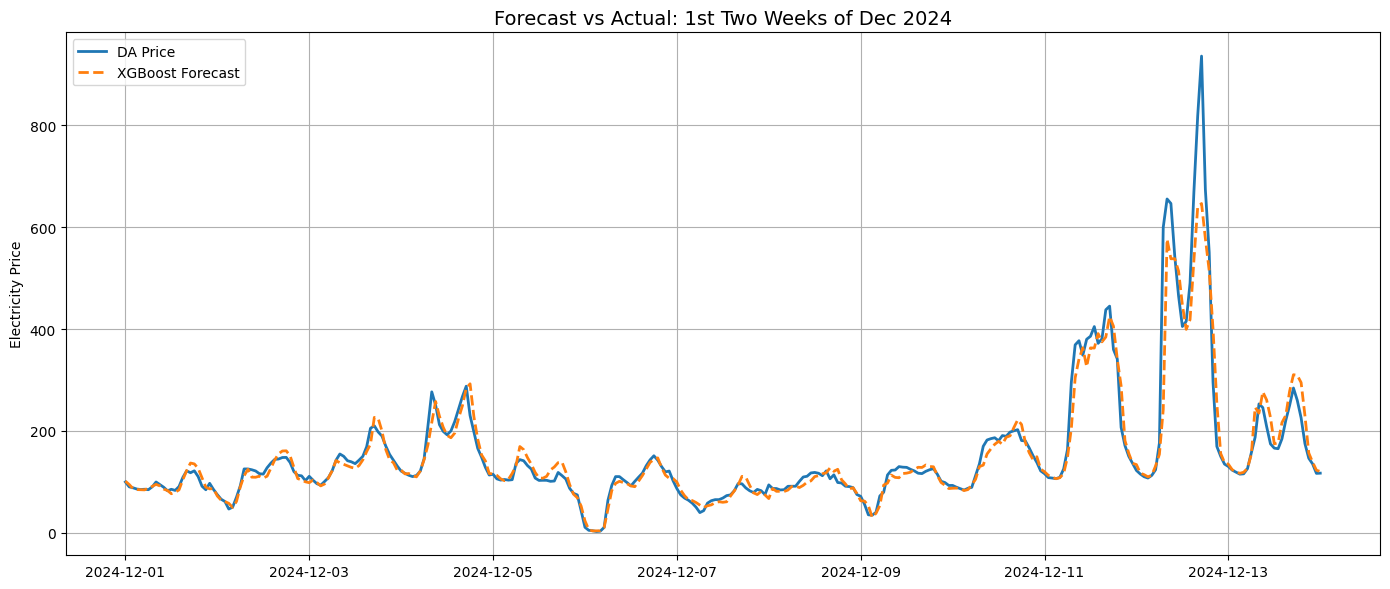

In [12]:
import matplotlib.pyplot as plt

# Define date range
start = '2024-12-01'
end = '2024-12-14'

# Mask for the selected range
mask = (y_test.index >= start) & (y_test.index <= end)

# Filter actual and predicted values
y_test_filtered = y_test[mask]

# If y_pred is a NumPy array, convert to Series with matching index
import pandas as pd
if not isinstance(y_pred, pd.Series):
    y_pred_filtered = pd.Series(y_pred[mask], index=y_test_filtered.index)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_test_filtered.index, y_test_filtered, label='DA Price', linewidth=2)
plt.plot(y_test_filtered.index, y_pred_filtered, label='XGBoost Forecast', linestyle='--', linewidth=2)
plt.title(f'Forecast vs Actual: 1st Two Weeks of Dec 2024', fontsize=14)
plt.xlabel('')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()